In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

/var/folders/tb/6k4p7fln11j9hxd3fppzryd80000gn/T/ipykernel_69386/2064205663.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Set de datos
Antes de armar la red neuronal vamos a importar los datos que se van a requerir usando pandas. Vamos a hacer un preprocesamiento para que el formato sea compatible con la red neuronal que armaremos

In [3]:
datos = pd.read_csv("Churn_Modelling.csv")
datos.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Imprimiento los primeros 5 elementos podemos ver que nuestra variable destino es la ultima columna **Exited** donde 1 es que se dio de baja y 0 que se quedó.

Es importante que en este paso vayamos pensando que tendremos que hacer con algunas columnas, ya sea eliminarlas, normalizarlas, llevar alguna transformación etc. Por ejemplo:
* RowNumber, CustomerID, Surname no nos dicen nada de utilidad. Predecir si alguien va a darse de baja por su ID de cliente, apellido o numero de renglon en la base de datos no nos va a dar buenos resultados. 
* Las columnas que son categoricas las vamos a transformar con **one hot encoding** (Genero y ubicacion geográfica)

In [4]:
# Separamos la ultima columna para que sea variable destino
datos_y = datos[datos.columns[-1]]
datos_y.head()


0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [5]:
# Eliminamos las columnas que no funcionarán
datos_x = datos.drop(columns=["RowNumber", "CustomerId", "Surname", "Exited"])
datos_x.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [6]:
# Convertimos en one hot encoding las columnas de genero y zona geográfica
datos_x = pd.get_dummies(datos_x)
datos_x.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,False,False,True,True,False


Ya se cuenta con una variable que tiene todas las entradas al modelo **datos_x** y otra con la salida **datos_y**. Para datos_x se cuenta con una columna por cada categoria de las variables Genero y Zona geofráfica.


# Escalado datos
Ahora vamos a escalar los valores para que esten dentro de un rango mas corto.

In [7]:
escalador = StandardScaler()
datos_x = escalador.fit_transform(datos_x)
print(datos_x)

[[-0.32622142  0.29351742 -1.04175968 ... -0.57380915  1.09598752
  -1.09598752]
 [-0.44003595  0.19816383 -1.38753759 ...  1.74273971  1.09598752
  -1.09598752]
 [-1.53679418  0.29351742  1.03290776 ... -0.57380915  1.09598752
  -1.09598752]
 ...
 [ 0.60498839 -0.27860412  0.68712986 ... -0.57380915  1.09598752
  -1.09598752]
 [ 1.25683526  0.29351742 -0.69598177 ... -0.57380915 -0.91241915
   0.91241915]
 [ 1.46377078 -1.04143285 -0.35020386 ... -0.57380915  1.09598752
  -1.09598752]]


# Dividir datos entre entrenamiento y test

In [8]:
datos_x.shape[0]

10000

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size = 0.2, random_state = 2)

In [10]:
print("X Train: {}, X Test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X Train: (8000, 13), X Test: (2000, 13), y_train: (8000,), y_test: (2000,)


In [11]:
n_entradas = X_train.shape[1]

# Tensores
Para poder procesar los datos en la red neuronal necesitamos que todos los datos estén en tensores, asi que haremos las conversiones necesarias

In [12]:
t_X_train = torch.from_numpy(X_train).float().to("cpu") #MPS
t_X_test = torch.from_numpy(X_test).float().to("cpu")
t_y_train = torch.from_numpy(y_train.values).float().to("cpu")
t_y_test = torch.from_numpy(y_test.values).float().to("cpu")
t_y_train = t_y_train[:,None]
t_y_test = t_y_test[:, None]


In [13]:
test = TensorDataset(t_X_test, t_y_test)
print(test[0])

(tensor([ 0.8326, -0.0879,  1.7245,  0.7569,  0.8077,  0.6461, -1.0307,  1.2390,
         0.9972, -0.5787, -0.5738,  1.0960, -1.0960]), tensor([1.]))


In [14]:
t_y_train

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]])

# Estructura de la red neuronal
Ahora vamos a armar una estructura básica de una red neuronal la cual va a recibir los datos de **X** para eventualmente poder predecir **y**

Para hacer esto tenemos que crear una Clase la cual hereda de nn.Module de torch.

In [15]:
class Red(nn.Module):
    
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 15)
        self.linear2 = nn.Linear(15, 8)
        # self.linear3 = nn.Linear(8,160)
        # self.linear4 = nn.Linear(160, 200)
        # self.linear5 = nn.Linear(200, 1)
        self.linear3 = nn.Linear(8, 1)
    
    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        # prediction = torch.sigmoid(input=self.linear3(prediction))
        # prediction = torch.sigmoid(input=self.linear4(prediction))
        # prediction = torch.sigmoid(input=self.linear5(prediction))
        pred_f = torch.sigmoid(input=self.linear3(pred_2))
        return pred_f


In [16]:
t_y_test[0]

tensor([1.])

In [17]:
%%time
lr = 0.001
epochs = 2000
estatus_print = 100

model = Red(n_entradas=n_entradas)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entranando el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

Arquitectura del modelo: Red(
  (linear1): Linear(in_features=13, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=1, bias=True)
)
Entranando el modelo

Epoch 100 	 Loss: 0.5554
Accuracy: 80.8499984741211

Epoch 200 	 Loss: 0.5075
Accuracy: 80.8499984741211

Epoch 300 	 Loss: 0.4918
Accuracy: 80.8499984741211

Epoch 400 	 Loss: 0.4841
Accuracy: 80.8499984741211

Epoch 500 	 Loss: 0.4776
Accuracy: 80.8499984741211

Epoch 600 	 Loss: 0.4702
Accuracy: 80.8499984741211

Epoch 700 	 Loss: 0.4619
Accuracy: 80.8499984741211

Epoch 800 	 Loss: 0.4532
Accuracy: 80.8499984741211

Epoch 900 	 Loss: 0.4449
Accuracy: 80.8499984741211

Epoch 1000 	 Loss: 0.4374
Accuracy: 80.8499984741211

Epoch 1100 	 Loss: 0.4312
Accuracy: 81.5

Epoch 1200 	 Loss: 0.4265
Accuracy: 81.6500015258789

Epoch 1300 	 Loss: 0.4225
Accuracy: 82.25

Epoch 1400 	 Loss: 0.4191
Accuracy: 82.55000305175781

Epoch 1500 	 Loss: 0.416
Accurac

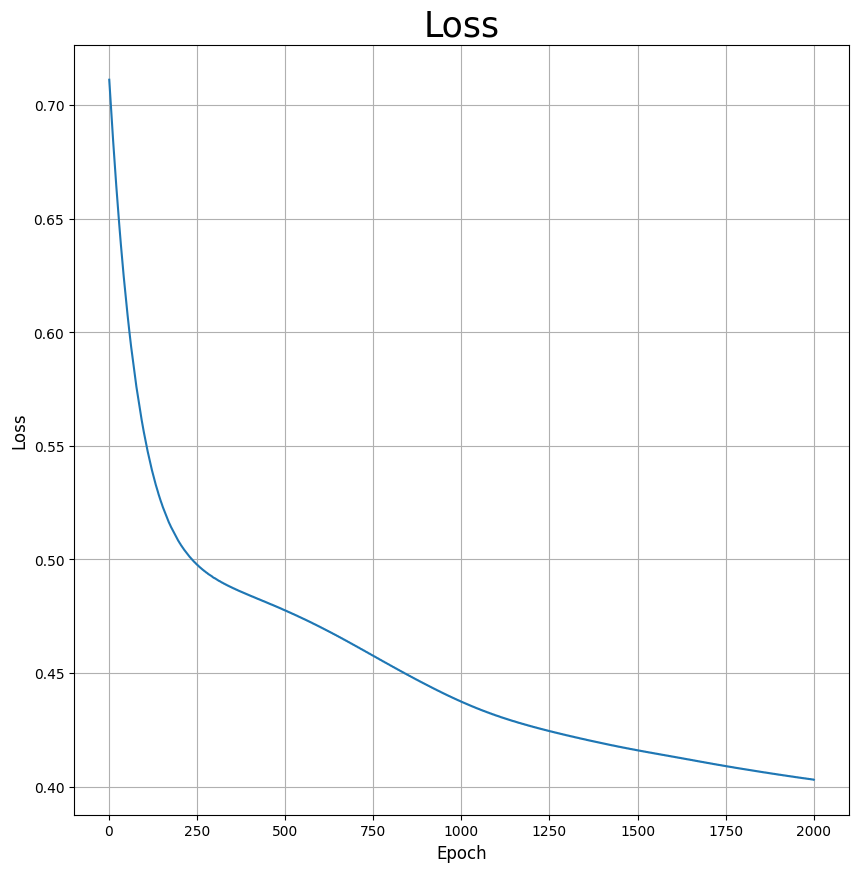

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

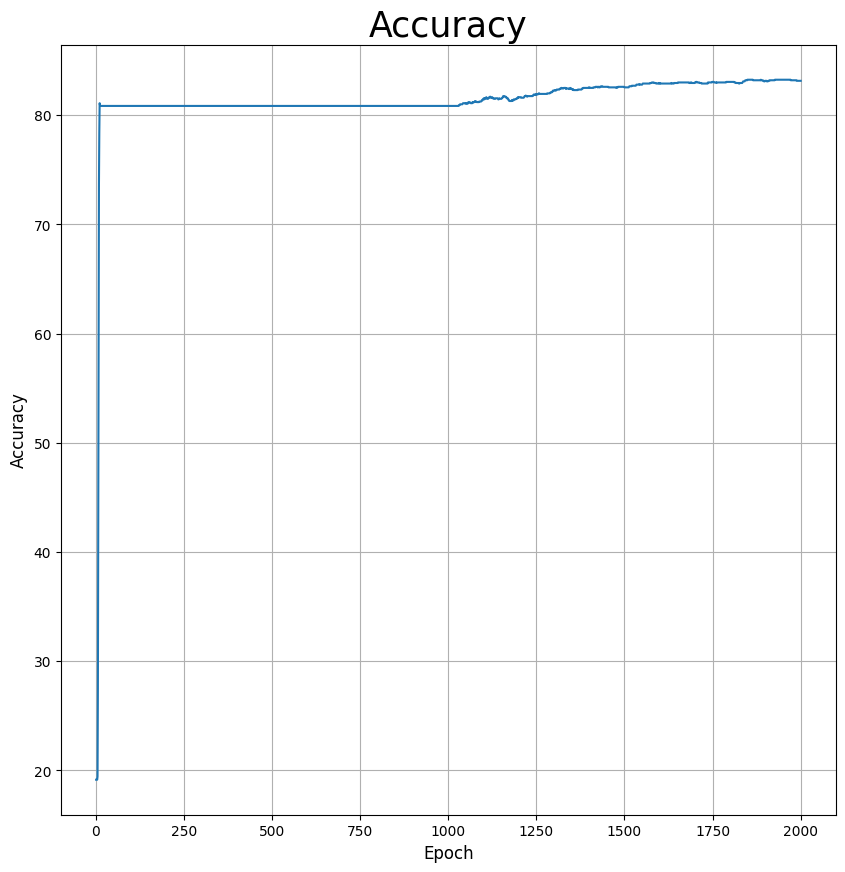

In [20]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()

In [21]:
t_X_test[5]

tensor([ 1.3810, -0.7554,  0.6871, -1.2258,  0.8077,  0.6461,  0.9702,  0.7497,
         0.9972, -0.5787, -0.5738, -0.9124,  0.9124])

In [22]:
prediccion = model(t_X_test[5])
print(prediccion)

tensor([0.0522], grad_fn=<SigmoidBackward0>)


In [23]:
t_y_test[5]

tensor([0.])